# McCabe Thiele Diagram für die Trennung von <br>H0-BT und H12-BT Gemischen aus dem Reaktionsteil der RD 

## 1. Vorbereitung

### 1.1 Import der Python Bibliotheken

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
#mpl.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d
from scipy.optimize import fsolve
from ipywidgets import interact
import ipywidgets as widgets

### 1.2 Konstanten für die Berechnungen

In [2]:
R = 8.314471
T_std = 298.15

In [3]:
M_H12BT=194.357; M_H0BT=182.261; M_H2=2.016

In [4]:
def T_CtoK(T):
    return T + 273.15
def T_KtoC(T):
    return T - 273.15

In [5]:
def rho_H2(p, T): # T_in_K and p_in_mbar
    return p*100 * M_H2/1000 / (R * T) # in kg/m^3

## 2. Function Definition: Plot McCabeThiele

In [6]:
def plotMcCabeThiele(T, xF, xB, q, ntimes_RGmin, MuEff):
    mpl.rcParams['axes.linewidth'] = 2 #set the value globally
    mpl.rcParams['font.size'] = 16
    mpl.rcParams['axes.xmargin'] = 0
    mpl.rcParams['axes.ymargin'] = 0

    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(22,10)) # plt.figure(figsize=(width,height in inch))
    #rect1 = ([0.,0.,.45,1]) # rect = [left, bottom, width, height]
    #ax1 = f.add_axes(rect1)
    ax1.set_title('McCabe Thiele for H0-/H12-BT at ~{:3.0f}°C'.format(T))
    ax1.set_xlim(0,1)
    ax1.set_ylim(0,1)
    ax1.xaxis.set_ticks(np.arange(0, 1.1, 0.5))
    ax1.yaxis.set_ticks(np.arange(0, 1.1, 0.5))
    ax1.set_xlabel('$x_{H12-BT}$', fontsize=22, fontweight='bold')
    ax1.set_ylabel('$y_{H12-BT}$ from ' + typ, fontsize=22, style='italic')
    plt.grid(b=True, which='major', color='#999999', linestyle='-', alpha=0.2)
    ax1.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    # ax.tick_params(axis="x", labelsize=16) # redundant
    # ax.tick_params(axis="y", labelsize=16) # redundant


    # plot x=y
    ax1.plot([0,1],[0,1], '-k', label='liq-composition')

    # plot VLE Gleichgewichtskurve
    xH12 = np.linspace(0,1, 100)
    yH12 = VLE(T,xH12)
    ax1.plot(xH12,yH12, '-b', label='vap-composition')

    # plot xF
    ax1.plot(xF, xF, marker='o', markersize=5, color='green')
    ax1.text(xF+0.01, xF-0.01, 'xF', color='green', fontsize=14)

    # plot xB
    ax1.plot(xB, xB, marker='o', markersize=5, color='red')
    ax1.text(xB+0.01, xB-0.01, 'xB', color='red', fontsize=14)

    # plot xD
    xD = VLE(T,xF)
    ax1.plot(xD, xD, marker='o', markersize=5, color='red')
    ax1.text(xD+0.01, xD-0.01, 'xD', color='red', fontsize=14)
    
    # plot xFqVLE - Einspeiselinie
    ax1.plot(*xFqVLE(T,xF,q), color='grey', linestyle='--', linewidth=1, clip_on=True)
    ax1.text(xFqVLE(T,xF,q)[0][0]+0.01, 0+0.01, 'xF/q', color='grey', fontsize=14, clip_on=True)

    # plot operating line at RGmin
    xFqVLE_intersect = xFqVLE(T,xF,q)
    RGmin = f_RGmin(xFqVLE_intersect,xB)
    ax1.plot([xB,xFqVLE_intersect[0][1]],[xB, xFqVLE_intersect[1][1]], color='grey', linestyle='--', linewidth=1, label='R_(G,min)={:3.1f}'.format(RGmin))
    
    # plot operating line in rectifying section at RG
    RG = ntimes_RGmin * RGmin
    xIntersect = line_intersection(([xB,0],[xB,-xB/RG]), ([xF/q,xF],[0,xF]))[0] # [0] gibt den ersten Wert des Schnittpunktes also den x-Wert zurück
    yIntersect = line_intersection(([xB,0],[xB,-xB/RG]), ([xF/q,xF],[0,xF]))[1] # [1] gibt den zweitn Wert des Schnittpunktes also den y-Wert zurück
    ax1.plot([xIntersect, xB], [yIntersect, xB], linestyle='-', linewidth='2', color='orange', label='op_line_rect with R_G={:3.1f}'.format(RG))
    
    # plot operating line in stripping section at RG
    # color picker with normalized rgb values: http://doc.instantreality.org/tools/color_calculator/
    ax1.plot([xIntersect, xD], [yIntersect, xD], linestyle='-', linewidth='2', color=[0.788,0.474,0.13], label='op_line_strip with R_G={:3.1f}'.format(RG))
    
    # plot Stufen
    df_Stufen, n_Stufen = make_Stufen(T, xF, xB, q, ntimes_RGmin, MuEff)
    ax1.plot(df_Stufen['x'], df_Stufen['y'], color='green', linewidth='1', label='# stages = {:.0f}'.format((df_Stufen.shape[0]-1)/2)) # no format: https://mkaz.blog/code/python-string-format-cookbook/
    
    # Additional text in plot
    P = P_VLE(T, xD)
    dp = 0.058*n_Stufen # [Cannon2013 pdf.8]
    T_Kopf = T_VLE(P,xD).item(0)
    T_Botm = T_VLE(P+dp,xB).item(0)
    str_dp = 'Druckverlust über die Kolonne mit {:1.0f} Stufen'.format(n_Stufen) + ' beträgt sehr grob {:3.2f}mbar.\n'.format(dp) # no format: https://mkaz.blog/code/python-string-format-cookbook/
    str_T_Kopf = 'Der Kondensatordruck müsste auf {:3.0f}mbar eingestellt werden'.format(P) + ' bei $T_{Kopf}$' + '={:3.0f}°C.\n'.format(T_Kopf) # no format: https://mkaz.blog/code/python-string-format-cookbook/
    str_T_Botm = 'Mit geg. Druckverlust und bei xB ist $T_{Sumpf}$' + '={:3.0f}°C.'.format(T_Botm)
    ax1.text(0.2,0.1,str_dp + str_T_Kopf + str_T_Botm, color='grey', fontweight='normal', fontsize=11, clip_on=True)
    
    ax1.margins(x=0, y=-0.25)
    ax1.legend(loc='upper left', frameon=True)
    
    ###################################################################################################################################################################
    Umsatz = 1 - xB
    mLOHC = mLOHC_pro_mH2(Umsatz)
    eta_FC = 0.5
    Vac_Leistungsaufnahme = 157.3
    
    ax2.set_title('Energy demands of the RD at ~{:3.0f}°C'.format(T))
    ax2.set_xlabel('Contributors', fontsize=22)
    ax2.set_ylabel('Energy demands in $\\frac{kJ}{g_{H2}}$', fontsize=22)
    ax2.set_xlim(-.5,5.5)
    ax2.set_ylim(0,120)
    data = {'$LHV_{H2}$': LHV_pro_mH2,
            '$Q_{preheat}$': Aufwaermenthalpie(mLOHC, T_CtoK(T)),
            '$Q_{reboil}$': Aufdampfenthalpie(mLOHC, RG),
            '$Q_{off,FC}$': FC_Enthalpieverlust(eta_FC), 
            '$\\Delta H_{r}$': dHr(T) / M_H2,
            '$W_{vacuum}$': Vakuum_E_Verbrauch( VLE(T,xF), T, Vac_Leistungsaufnahme),}
    group_data = list(data.values())
    group_names = list(data.keys())
    ymax = np.ceil(np.max(group_data)/25)*25
    ax2.set_ylim(0, ymax) # set new max if one of the values was higher than 120 kJ/g_H2
    ax2.yaxis.set_ticks(np.arange(0, ymax, 25))
    ax2.bar(group_names, group_data, color='k', align='center', width=0.7)
    
    if Aufdampfenthalpie(mLOHC, RG) + Vakuum_E_Verbrauch( VLE(T,xF), T, Vac_Leistungsaufnahme) >= LHV_pro_mH2: # dark red no go!
        warning = '$ Q_{reboil} + Q_{pre} + W_{vac} > LHV_{H2} $'
        ax2.text(5.2,0.95*ymax, warning, ha='right', va='center', color=[0.839, 0, 0.078], fontweight='bold', fontsize=16, clip_on=True)
        ax2.set_facecolor((0.839, 0, 0.078, 0.4))
    elif Aufdampfenthalpie(mLOHC, RG) >= FC_Enthalpieverlust(eta_FC): # light red warning
        warning = '$Q_{reboil} > Q_{off,FC}$'
        ax2.text(5.2,0.95*ymax, warning, ha='right', va='center', color=[1, 0.101, 0.101], fontweight='bold', fontsize=16, clip_on=True)        
        ax2.set_facecolor((1, 0.101, 0.101, 0.4))
    elif Aufdampfenthalpie(mLOHC, RG) <= dHr(T) / M_H2: # yellow hint
        warning = '$Q_{reboil} < \Delta H_r$'
        ax2.text(5.2,0.95*ymax, warning, ha='right', va='center', color=[1, 0.819, 0.219], fontweight='bold', fontsize=16, clip_on=True)  
        ax2.set_facecolor((1, 0.996, 0.101, 0.4))
    
    #f.savefig(GCname + ".png", dpi=400)

## 3. Function Definition: Trennfaktor, VLE

#### Trennfaktor:
$\alpha =  \frac{   {\gamma_{H12BT}(x_{H12BT}, T)}  \cdot  {p^{LV}_{H12BT}(T)}}      {   {\gamma_{H0BT}(x_{H0BT}, T)}  \cdot  {p^{LV}_{H0BT}(T)}   } = a + b x + c T + d  x T + e x^2 + f  T^2 $ 

In [7]:
def Trennfaktor(TinC, xH12BT): # Dampfdruckdaten von MG und UNIFAC
    if typ == 'UNIFAC':
        popt = [3.2630900297436662, -3.004295927930803, -0.005414768240235719, 0.004139908035693467, 0.7525345797528048, 3.417202183366236e-06]
    elif typ == 'UNIFAC_D':
        popt = [ 2.2602772128508835, -0.3990448060046183, -0.005559122341413845, 0.005218818733797906, -0.5279084101049865, 3.263574193954477e-06]    
    elif typ == 'experimental_fit':
        popt = [ 27.39815102908694, -17.149527717279845, -0.15095897708706832, 0.047650488219361395, 3.6459997204529606, 0.0002145007584464491]
    else:
        print('No type of calculating alpha was specified. Specify as \'UNIFAC\' or \'experimental_fit\'')
    
    a, b, c, d, e, f = popt
    T = TinC
    x = xH12BT
    alpha = a  +  b*x  +  c*T + d*x*T + e*x**2 + f*T**2  # quadratic function alpha = f(xH12BT, T)
    return alpha

T = 200
typ = 'UNIFAC_D'
print('Trennfaktor bei Berechnung mit ' + typ + ' bei T= {:3.0f}°C und xH12=0.5 ist alpha='.format(T) + str(Trennfaktor(T,0.5)) + '.')

Trennfaktor bei Berechnung mit UNIFAC_D bei T= 200°C und xH12=0.5 ist alpha=1.4693780801775285.


#### Gleichgewichtskurve
$y_{H12} = \frac{\alpha \cdot x_{H12}}{1+x_{H12} \cdot \left(\alpha-1 \right)}= \frac{\alpha(T,x_{H12}) \cdot x_{H12}}{1+x_{H12} \cdot \left(\alpha \left( T,x_{H12} \right )-1 \right)}$

In [8]:
def VLE(TinC, xH12):
    alpha = Trennfaktor(TinC, xH12)
    yH12 = alpha * xH12 / (  1 + xH12*( alpha-1 )  )
    return yH12

xF = 0.6
print('Der Dampfanteil von H12-BT in der Trennstufe über dem Feed bei T= {:3.0f}°C und xH12F={:3.2f} ist yH12F='.format(T,xF) + str(VLE(T,xF)) + '.' )

Der Dampfanteil von H12-BT in der Trennstufe über dem Feed bei T= 200°C und xH12F=0.60 ist yH12F=0.6888292895465565.


In [9]:
xH12 = np.linspace(0,1, 100)
yH12 = VLE(T, xH12)
print('Maximum alpha={:3.2f}'.format(np.max(Trennfaktor(T,xH12))) + ' at xH12={:0.0f}' .format(xH12[np.argmax(Trennfaktor(T,xH12))]*100) + '%')
print('Azeotrop would be at xH12={:0.0f}'.format(xH12[np.argmin(abs(Trennfaktor(T,xH12)-1))]*100) + '%')

Maximum alpha=1.48 at xH12=61%
Azeotrop would be at xH12=0%


## 4. Function Definition: Zeichnen McCabe-Thiele-Diagram

#### Minimales Aufdampfverhältnis
[Mersmann06 p.250]<br>
 * Die RD ist eine reine Abtriebskolonne. Daher finden das Erstellen des McCabe Thiele Diagramms über den Abtriebsteil statt.
 * Für die Arbeitslienie des Abtriebsteils folgt aus den Mengen und Stoffbilanzen um den Kolonnensumpf ergibt sich folgende Geradengleichung:
   * $y =\frac{R_G+1}{R_G} \cdot x-\frac{1}{R_G}\cdot x_B$
 * Die Arbeitslinien dürfen die Gleichgewichtskurve weder berühren noch schneiden.
 * Daraus ergibt sich, dass die Gerade eine maximale Steigung y=mx+t haben darf. Die maximale Steigung m ist für eine Gerade erreicht die durch die Punkte ``[xB,xB]`` und ``[xF,VLE(xF]`` geht (gilt für q=1).
 * Für ``x=0`` kann der y-Achsenabschnitt t der Geradengleichung $R_{G,min}$ liefern:
   * $t =  \frac{R_G+1}{R_G} \cdot 0 -\frac{1}{R_G}\cdot x_B$
   * $R_{G,min} = \frac{x_B}{-t}$

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcT2koLZhCK2nBa85FESgtrYNCKtrvmov21qFit5RgnWS6M7bf9A&usqp=CAU" width="250" align="left">

In [10]:
# Gibt die Schnittpunktsgerade zurück, die bei der x-Achse [xF/q,0] über [xF,xF] geht bis dahin wo das VLE geschnitten wird 

def xFqVLE(T, xF, q):
    
    def VLE_T(xH12):
        return VLE(T, xH12)
    
    if q == 1:
        line_xFqVLE = [[xF,xF], [0,VLE_T(xF)]]
    elif q == 0:    
        xH12 = np.linspace(0,1, 1000)
        yH12 = VLE_T(xH12)
        g = interp1d(yH12, xH12, kind='linear')
        line_xFqVLE = [[1,g(xF).item(0)],[xF, xF]]
    else:
        mt_line_xFqVLE = np.polyfit([xF/q, xF], [0, xF], 1)
        line_mt = np.poly1d(mt_line_xFqVLE) 
        
        def findIntersection(fun1,fun2,x0):
            return fsolve(lambda x : fun1(x) - fun2(x),x0)

        intersect_xH12 = findIntersection(line_mt,VLE_T,0.5).item(0)
        intersect_yH12 = line_mt(intersect_xH12).item(0)

        line_xFqVLE = [[xF/q,intersect_xH12], [0,intersect_yH12]]
    return line_xFqVLE # Schnittpunktsgerade durch zwei Punkte mit x=[xF/q,0] und y=[xF,xF]

q = 1
print('Die Schnittpunktgerade von der x-Achse bei [xF/q,0] durch den Feedpunkt [xF,xF] bis zur VLE-Kurve bei T= {:3.0f}°C, xH12F={:3.2f} und dem kalorischen Zustand des Feeds q = {:2.1f} ist Schnittpunktsgerade='.format(T,xF,q) + str(xFqVLE(T, xF, q)) + '.' )

Die Schnittpunktgerade von der x-Achse bei [xF/q,0] durch den Feedpunkt [xF,xF] bis zur VLE-Kurve bei T= 200°C, xH12F=0.60 und dem kalorischen Zustand des Feeds q = 1.0 ist Schnittpunktsgerade=[[0.6, 0.6], [0, 0.6888292895465565]].


In [11]:
def f_RGmin(xFqVLE_intersect,xB):
    intersect_xH12 = xFqVLE_intersect[0][1] # x von da wo die Einspeisegerade die Gleichgewichtskurve schneidet
    intersect_yH12 = xFqVLE_intersect[1][1] # y von da wo die Einspeisegerade die Gleichgewichtskurve schneidet
    
    # Die Arbeitslinie beim minimalen Aufdampfverhältnis ist eine Gerade durch die d. [x,y] gegebenen Punkte [xB,xB] und [intersect_xH12,intersect_yH12]
    m_RGmin, t_RGmin = np.polyfit([xB, intersect_xH12], [xB, intersect_yH12], 1) # fit a polynomial of order 1 so y=mx+t to the two given points
    RGmin = xB/-t_RGmin
    return RGmin

xB = 0.05
xFqVLE_intersect = xFqVLE(T, xF, q)
print('Das minimale Aufdampfverhältnis ergibt sich aus dem y-Achsenabschnitt einer Geraden durch die Punkte [Schnittpunktsgerade_von_vorher, VLE-Kurve] und [xB,xB] bei T={:3.0f}°C, xH12F={:3.2f}, q={:2.1f} und xB={:3.2f} zu RG='.format(T,xF,q, xB) + str(f_RGmin(xFqVLE_intersect, xB)) + '.' )

Das minimale Aufdampfverhältnis ergibt sich aus dem y-Achsenabschnitt einer Geraden durch die Punkte [Schnittpunktsgerade_von_vorher, VLE-Kurve] und [xB,xB] bei T=200°C, xH12F=0.60, q=1.0 und xB=0.05 zu RG=6.191651456491269.


#### Arbeitslinien mit eingestelltem Aufdampfverhältnis

In [12]:
def Einspeiselinie(T,xF,q):
    if q == 1:
         def linie(xH12):
            return xF
    else:
        def linie(xH12):
            g = interp1d( *xFqVLE(T,xF,q), fill_value='extrapolate')
            return g(xH12)
    return linie

print('Die Einspeiselinie wurde vorher bereits durch zwei Punkte defniiert als Schnittpunktgerade von der x-Achse bei [xF/q,0] durch den Feedpunkt [xF,xF] bis zur VLE-Kurve.')
print('Diese Definition gibt eine Funktion zurück, mit deren Hilfe man einen y-Wert auf der Einspeiselinie bei gegebenem x-Wert berechnen lassen kann.')
print('So ist bei für die Punkte in x_Einspeiselinie=[0, 0.69, 0.7, xF/q, 0.9] folgende y_Einspeiselinie=', end='')
print(str(Einspeiselinie(T,xF,q)(np.array([0, 0.69, 0.7, xF/q, 0.9]))) + ' (bei q=1 und einer senkrechten Gerade gibts nur einen Wert bei y=xF zurück)')

Die Einspeiselinie wurde vorher bereits durch zwei Punkte defniiert als Schnittpunktgerade von der x-Achse bei [xF/q,0] durch den Feedpunkt [xF,xF] bis zur VLE-Kurve.
Diese Definition gibt eine Funktion zurück, mit deren Hilfe man einen y-Wert auf der Einspeiselinie bei gegebenem x-Wert berechnen lassen kann.
So ist bei für die Punkte in x_Einspeiselinie=[0, 0.69, 0.7, xF/q, 0.9] folgende y_Einspeiselinie=0.6 (bei q=1 und einer senkrechten Gerade gibts nur einen Wert bei y=xF zurück)


In [13]:
def op_line_rect(T,xF,xB,q, ntimes_RGmin):
    xFqVLE_intersect = xFqVLE(T, xF, q)
    RGmin = f_RGmin(xFqVLE_intersect, xB)
    RG = ntimes_RGmin * RGmin
    def linie(xH12):
        xH12 = np.array(xH12)
        return (RG+1)/RG * xH12 - 1/RG * xB
    return linie

xFqVLE_intersect = xFqVLE(T, xF, q)
RGmin = f_RGmin(xFqVLE_intersect, xB)
ntimes_RGmin = 1.3
print('Die Arbeitslinie im Abtriebsteil geht durch die Punkte [xB,xB] und durch einen PUnkte auf der Einspeiselinie zwischen [xF,xF] und VLE-Kurve.')
print('Bei T={:3.0f}°C, xF={:3.2f}, xB={:3.2f}, q={:2.1f}, RGmin={:3.1f}, und dem gewählten n=RG/RGmin={:2.1f} lässt sich für x=[0, xB, 0.695, 0.7, 0.9] folgende Werte auf der Abtriebsgeraden berechnen y='.format(T,xF,xB,q,RGmin,ntimes_RGmin) + str(op_line_rect(T,xF,xB,q, ntimes_RGmin)([0, xB, 0.695, 0.7, 0.9])))

Die Arbeitslinie im Abtriebsteil geht durch die Punkte [xB,xB] und durch einen PUnkte auf der Einspeiselinie zwischen [xF,xF] und VLE-Kurve.
Bei T=200°C, xF=0.60, xB=0.05, q=1.0, RGmin=6.2, und dem gewählten n=RG/RGmin=1.3 lässt sich für x=[0, xB, 0.695, 0.7, 0.9] folgende Werte auf der Abtriebsgeraden berechnen y=[-0.00621184  0.05        0.77513272  0.7807539   1.00560125]


#### Zwei Arten den Schnittpunkt zweier Linien zu finden:
 - 2020-04-21 -> Beide liefern erleichternderweise das selbe Ergebnis
   * line_intersection: Beide Linien werden nur durch jeweils zwei Punkte [x1,x2] und  [y1,y2] definiert. Diese Methode erscheint etwas einfacher.
   * findIntersect_...: Beide Linien werden durch aufwändige Funktions-Definition (incl. Ausnahmeregelungen für q=1 und q=0) spezifiziert: Die `def` der Geraden sind im Unterpunkt 'Arbeitslinien mit eingestelltem Aufdampfverhältnis' zu finden. Der Schnittpunkt ergibt sich aus einer der Nullstelle der Differenz beider Funktionen.

In [14]:
# ( [A_line1x,B_line1x] , [A_line1y,B_line1y] )  ,  ( [C_line2x,D_line3x] , [C_line2y,D_line2y] )
# where the straight line1 is defined by points A and B
# where the straight line2 is defined by points C and D

def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[0][1], line2[0][0] - line2[0][1])
    ydiff = (line1[1][0] - line1[1][1], line2[1][0] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')

    # egal wie rum line[1][0] oder line[0][1]
    # lin1 = ([ line1[0][0], line1[1][0] ] , [line1[0][1], line1[1][1]] )
    # lin2 = ([ line2[0][0], line2[1][0] ] , [line2[0][1], line2[1][1]] )
    
    d = (det(*line1), det(*line2))
    x_intersect = det(d, xdiff) / div
    y_intersect = det(d, ydiff) / div
    return [x_intersect, y_intersect]

# line_intersection(  ( [A_line1x,B_line1x] , [A_line1y,B_line1y] )  ,  ( [C_line2x,D_line3x] , [C_line2y,D_line2y] )  )
RG = ntimes_RGmin * RGmin
RGmin, RG, -xB/RG, line_intersection(  ( [xB,0] , [xB,-1/RG*xB] )  ,  ( [xF,xF/q] , [xF,0] )  )

(6.191651456491269,
 8.04914689343865,
 -0.006211838429828887,
 [0.6, 0.6683302227281178])

In [15]:
def findIntersect_Einespeiselinie_op_line_rect(T,xF,xB,q,ntimes_RGmin, fun1,fun2):
    xH12 = np.linspace(0,1,2)
    
    einsp_ = fun1(T,xF,q)
    op_re_ = fun2(T,xF,xB,q,ntimes_RGmin)
    Dy = einsp_(xH12) - op_re_(xH12)
    
    g = interp1d( Dy,xH12, fill_value='extrapolate')
    
    xIntersect = g(0) # Dy soll 0 sein. 
    yIntersect = op_re_(xIntersect)
    
    return [xIntersect, yIntersect]

findIntersect_Einespeiselinie_op_line_rect(T,xF,xB,q,ntimes_RGmin, Einspeiselinie, op_line_rect)

[array(0.53922079), 0.6]

#### Arbeitslinie verpackt in Funktionen die wahlweise x- und y- Werte zurückgeben können 
 

##### Definition der gesamten Operating-Line durch die 5 Punkte durch die sie geht

In [16]:
# operating lines
def oplines(T, xF, xB, q, ntimes_RGmin):
    xD = VLE(T,xF)
    xFqVLE_intersect = xFqVLE(T, xF, q)
    RGmin = f_RGmin(xFqVLE_intersect, xB)
    RG = ntimes_RGmin * RGmin
    xIntersect = line_intersection(([xB,0],[xB,-xB/RG]), ([xF/q,xF],[0,xF]))[0] # [0] gibt den ersten Wert des Schnittpunktes also den x-Wert zurück
    yIntersect = line_intersection(([xB,0],[xB,-xB/RG]), ([xF/q,xF],[0,xF]))[1] # [1] gibt den zweitn Wert des Schnittpunktes also den y-Wert zurück
    return [[ 0, xB, xIntersect, xD, 1 ]  ,  [ 0, xB, yIntersect, xD, 1 ]]

print('Die Operating Linie wird durch die 5 Punkte [0,0], [xB,xB], [Einspeiselinie, Abtriebsgerade], [xD,xD], [1,1] definiert. \nDamit ist bei T={:3.0f}°C, xF={:3.2f}, xB={:3.2f}, q={:2.1f}, RG={:3.1f}'.format(T,xF,xB,q,RG) + ' x_op_line=' + str(oplines(200,0.6,0.05,0.85,1.3)[0]) + ' und y_op_line=' + str(oplines(200,0.6,0.05,0.85,1.3)[1]))

Die Operating Linie wird durch die 5 Punkte [0,0], [xB,xB], [Einspeiselinie, Abtriebsgerade], [xD,xD], [1,1] definiert. 
Damit ist bei T=200°C, xF=0.60, xB=0.05, q=1.0, RG=8.0 x_op_line=[0, 0.05, 0.5895354904023531, 0.6888292895465565, 1] und y_op_line=[0, 0.05, 0.6592988877199993, 0.6888292895465565, 1]


##### Rückgabe eines y-Wertes auf der Operating-Line für einen vorgegebenen x-Wert

In [17]:
def oplines_interp_y(T, xF, xB, q, ntimes_RGmin, y):
    xx = oplines(T, xF, xB, q, ntimes_RGmin)[0]
    yy = oplines(T, xF, xB, q, ntimes_RGmin)[1]
    g = interp1d(yy,xx)
    x = g(y)
    return x

print('Für einen gegebenen x-Wert=0.1 bei T={:3.0f}°C, xF={:3.2f}, xB={:3.2f}, q={:2.1f}, ntimes_RGmin={:3.1f}'.format(T,xF,xB,q,ntimes_RGmin) + 'berechnet sich y_op_line=' + str(oplines_interp_y(T,xF,xB,q,ntimes_RGmin,   0.1)))

Für einen gegebenen x-Wert=0.1 bei T=200°C, xF=0.60, xB=0.05, q=1.0, ntimes_RGmin=1.3berechnet sich y_op_line=0.09447461726626916


##### Zeige, dass die Berechnung von y-Werten auf gegebene x-Werte auf der Operating-Line richtig funktioniert

In [18]:
# show that operating lines is working correctly
T=200;xF=0.6;xB=0.05;q=0.85;ntimes_RGmin=1.3;
def oplines_interp_y_plot(y):
    
    plt.plot(*oplines(T, xF, xB, q, ntimes_RGmin), 'k-')
    x = oplines_interp_y(T, xF, xB, q, ntimes_RGmin, y)
    plt.plot(x,y,'or')
    plt.show()

interact(oplines_interp_y_plot, 
         y=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.05))

interactive(children=(FloatSlider(value=0.05, description='y', max=1.0, step=0.01), Output()), _dom_classes=('…

<function __main__.oplines_interp_y_plot(y)>

#### Stufenkonstruktion mit Murphree vapor efficiency
 * Die Murphree vapour phase efficiency ist der Anteil der vertikalen Distanz von Operating Linie zur VLE-Kurve.
   * Bei 50 % Effizient ist also der vertikale Abstand von Operatin-Linie zur VLE-Linie 50%
 * Für die Murphree liquid efficiency wird beim Zeichnen der Stufenkonstruktion nur (abwärtsgerichtet im Verstärkungsteil) bei jeder Stufe 50% nach links gegangen, der horizontale Abstand von der Operating-Linie zur VLE-Linie ist also 50%.

In [19]:
x0 = 0.05

MuEff = 0.9
g_op_y = interp1d(*oplines(T, xF, xB, q, ntimes_RGmin))
MuDiff = (1-MuEff) * abs((VLE(T,x0)-g_op_y(x0)))
print('y Operating Line: ', end='') ; print(g_op_y(x0))
print('y VLE:          : ', end='') ; print(VLE(T, x0))
print('')
print(MuDiff)
print(VLE(T, x0) - MuDiff)

y Operating Line: 0.05
y VLE:          : 0.06449618765165022

0.0014496187651650211
0.0630465688864852


20.0

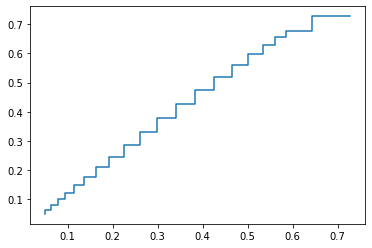

In [20]:
def make_Stufen(TinC, xF, xB, q, ntimes_RGmin, MuEff):

    #Stufen = np.empty([0, 3], dtype=float)
    Stufenxy =  np.array([xB, xB], dtype=float)
    
    xD = VLE(TinC,xF)
    x1 = xB
    
    i = 0
    while x1 < xD:
        x0 = x1; # print('x0 = {:3.2f}'.format(x0))
        g_op_y = interp1d(*oplines(TinC, xF, xB, q, ntimes_RGmin))
        MuDiff = (1-MuEff) * abs((VLE(TinC,x0)-g_op_y(x0)))
        y1 = VLE(TinC, x0) - MuDiff; # print('y1 = {:3.2f}'.format(y1))
        x1 = oplines_interp_y(TinC, xF, xB, q, ntimes_RGmin, y1); # print('x1 = {:3.2f}'.format(x1))
        #Stufen = np.vstack([Stufen, [x0, y1, x1]])
        Stufenxy = np.vstack([Stufenxy, [x0,y1], [x1,y1]])
        i+=1
    df_Stufen = pd.DataFrame(Stufenxy, columns = ['x', 'y'])
    n_Stufen = (df_Stufen.shape[0]-1)/2
    
    return df_Stufen, n_Stufen

df_Stufen, n_Stufen = make_Stufen(200,0.6,0.05,0.85,1.3,1)
plt.plot(df_Stufen['x'], df_Stufen['y'])
n_Stufen

## 5. Sich einstellende Temperatur im Sumpf bei gegebenem Kondensatordruck

In [21]:
def pLV_H12BT(T):  # T in °C and pLV in mbar | MGs gemessene Dampfdruckkurve gefittet
    A = 11.4056281872818;    B = 4136.25631406511;    C = 101.419070492597 
    
    T = T + 273.15
    pLV_H12BT = 10 ** (A - B / (T + C)) / 100 # berechne den Dampfdruck von H12BT in mbar für eine gegebene Temperatur in °C
    return pLV_H12BT

def pLV_H0BT(T):  # T in °C and pLV in mbar | MGs gemessene Dampfdruckkurve gefittet
    A = 11.6830423129098;     B = 4464.31133596868;     C = 111.960865653925 
    
    T = T + 273.15
    pLV_H0BT = 10 ** (A - B / (T + C)) / 100 # berechne den Dampfdruck von H0BT in mbar für eine gegebene Temperatur in °C
    return pLV_H0BT

def gammaH12BT(T, xH12BT): # UNIFAC und beachte: f(xH12BT)=f(1-xH0BT)
    if typ == 'UNIFAC':
        popt = [ 1.8451356505525132, -1.5863987167755635, -0.0013452351126243462, 0.0011746330714486036, 0.7500320673051, 8.822067998791486e-07]
    elif typ =='UNIFAC_D':
        popt = [ 1.2763726792579544, -0.007993528582923397, -0.002218013979514285, 0.0018522601200481924, -0.2792761499441165, 1.5598165702775456e-06]
    elif typ == 'experimental_fit':
        popt = [1,0,0,0,0,0]
    else:
        print('No type of calculating alpha was specified. Specify as \'UNIFAC\' or \'experimental_fit\'')    
    
    def func(x, T, a, b, c, d, e, f):
        gammaH12 = a  +  b*x  +  c*T + d*x*T + e*x**2 + f*T**2  # quadratic function alpha = f(xH12BT, T)
        return gammaH12    
    gammaH12 = func( xH12BT, T, *popt)    
    return gammaH12

def gammaH0BT(T, xH12BT): # UNIFAC
    if typ == 'UNIFAC':
        popt = [ 0.9911630540010934, 0.1943999822667261, -0.00013246671872439077, -0.0013371488830025073, 0.654625729347227, 9.578039853648297e-07]
    elif typ =='UNIFAC_D':
        popt = [ 1.014065698576433, 0.2706523381737909, -0.00038708748308573666, -0.0018840007656849027, 0.10525087482478367, 1.6038463158145088e-06]
    elif typ == 'experimental_fit':
        popt = [1,0,0,0,0,0]
    else:
        print('No type of calculating alpha was specified. Specify as \'UNIFAC\' or \'experimental_fit\'')        
    
    def func(x, T, a, b, c, d, e, f):
        gammaH0 = a  +  b*x  +  c*T + d*x*T + e*x**2 + f*T**2  # quadratic function alpha = f(xH12BT, T)
        return gammaH0    
    gammaH0 = func( xH12BT, T, *popt)    
    return gammaH0

pLVH12BT(200°C) = 160.97mbar.
P_VLE(200°C,xH12=1) = 157.48mbar.
pLVH0BT(200°C) = 113.03mbar.
P_VLE(200°C,xH12=0) = 113.12mbar.


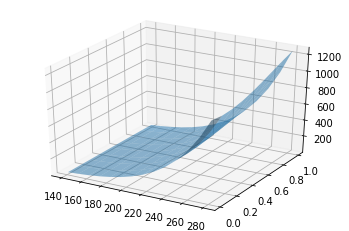

In [22]:
def P_VLE(TinC, xH12): # Temperatur in °C
    T = TinC
    pLVH12 = pLV_H12BT(T)
    pLVH0 = pLV_H0BT(T)
    gH12 = gammaH12BT(T, xH12)
    gH0 = gammaH0BT(T, xH12)
    P = xH12*pLVH12*gH12 + (1-xH12)*pLVH0*gH0
    if typ == 'experimental_fit':
        print('P was calculated assuming ideality since no activity coefficients are available for experimental x-y-Data.')
    return P

TT, xx = np.meshgrid(np.linspace(140,281,14), np.linspace(0.01,0.99,9))
Ts = TT.flatten()
xs = xx.flatten()

Ps = P_VLE(Ts, xs)    
P_3d = Ps.reshape(np.shape(TT))

fig = plt.figure()
ax = plt.axes(projection="3d")
ax.plot_surface(TT, xx, P_3d, rstride=1, cstride=1, alpha=0.5)

### Es gibt durch die gefitteten gammas kleien Abweichungen zur Dampfdruckkuve
print('pLVH12BT(200°C) = {:3.2f}mbar.'.format(pLV_H12BT(200)) )
print('P_VLE(200°C,xH12=1) = {:3.2f}mbar.'.format(P_VLE(200,1)) )
print('pLVH0BT(200°C) = {:3.2f}mbar.'.format(pLV_H0BT(200)) )
print('P_VLE(200°C,xH12=0) = {:3.2f}mbar.'.format(P_VLE(200,0)) )

In [23]:
np.linspace(0.01,0.99,15)

array([0.01, 0.08, 0.15, 0.22, 0.29, 0.36, 0.43, 0.5 , 0.57, 0.64, 0.71,
       0.78, 0.85, 0.92, 0.99])

In [24]:
TT, xx = np.meshgrid(np.linspace(140,280,15), np.linspace(0.01,0.99,15))
Ts = TT.flatten()
xs = xx.flatten()
Ps = P_VLE(Ts, xs)  
T_VLE = interp2d(Ps, xs, Ts, kind='linear')

T_VLE(200,0.99).item(0)

C:\Users\t.ruede\Anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=19,16 m=225 fp=0.000428 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


208.24483295035785

## 6. Plot Energiebalken
 * 1 g Wasserstoff kann bei Vollumsatz aus 16 g H12-BT freigesetzt werden
 * $ 119.96 \frac{kJ}{g_{H2}} $
 * Die Aufwärmenthalpie des LOHCs von 20°C auf 200°C Siedetemperatur (Reaktionsbedingungen in der RD) beträgt $ 5.9 \frac{kJ}{g_{H2}} $
 * Die Aufdampfenthalpie bei geg. Verdampfungsenthalpie und Aufdampfverhältnis und bei 200 °C Siedetemperatur sollte niedriger als der Energieverlust der Brennstoffzelle sein.
 * Die Reaktionsenthalpie bei 200 °C sollte niedriger sein als die Aufdampfenthalpie.

### 6.1 LHV pro Gramm Wasserstoff

In [25]:
LHV_pro_mH2 = 119.96 # kJ/g

### 6.2 Benötigte Feedmasse LOHC um 1 g Wasserstoff freizusetzen

In [26]:
def mLOHC_pro_mH2(Umsatz):
    return M_H12BT / (6*M_H2) / Umsatz # entspricht dem Feedmassenstrom
mLOHC = mLOHC_pro_mH2(1)
mLOHC

16.067873677248677

### 6.3 Aufwärmenthalpie für Feedmasse LOHC

In [27]:
def cp_H12BT(TinK):  # T in K and output in J/g/K | [Müller15 Table S1]
    A = 0.00339713;    b = 0.73472925
    Tmin = 190-273.15 # °C
    Tmax = 394-273.15 # °C    
    cp = A * TinK + b # berechne die Wärmekapazität von H12BT in J/g/K für eine gegebene Temperatur in K
    return cp

In [28]:
def Aufwaermenthalpie(mLOHC, TinK): 
    mean_cp_H12BT = ( cp_H12BT(T_std) + cp_H12BT(T) ) /2
    return mean_cp_H12BT * mLOHC * abs(T-T_std) / 1000
Aufwaermenthalpie(mLOHC, T_CtoK(200))

2.4931287512678924

### 6.4 Aufdampfenthalpie

In [29]:
def dHvap_H0BT(TinK):  # [Müller15]
    b_H0BT = -98264.58; Dgl_C_pm0_H0BT = -83.6
    Tmin = 373-273.15 # °C
    Tmax = 633-273.15 # °C    
    dHvap = (-b_H0BT + Dgl_C_pm0_H0BT * TinK) / 1000 # berechne die Verdampfungsenthalpie in kJ/mol für eine gegebene Temperatur in K
    return dHvap
dHvap_H0BT(T_CtoK(200))

58.70924000000001

In [30]:
def Aufdampfenthalpie(mLOHC_pro_mH2, R_G):
    return R_G * dHvap_H0BT(T) / M_H0BT * mLOHC_pro_mH2
Aufdampfenthalpie(mLOHC, 27.6)

198.4124145588944

### 6.5 Wärmeverlust der Brennstoffzelle

In [31]:
def FC_Enthalpieverlust(eta_FC):
    return eta_FC * LHV_pro_mH2 
FC_Enthalpieverlust(0.5)

59.98

### 6.6 Reaktionsenthalpie

In [32]:
def dHr(T): # Reaktionsenthalpie pro freigesetztes mol Wasserstoff
    Tmin = 298-273 # °C
    Tmax = 400-273 # °C  danach lineare Extrapolation der cp Daten von [Müller15]
  
    cp_a_H12=0.73472925; cp_b_H12=0.00339713
    cp_a_H0=0.76712874; cp_b_H0=0.00259635
    cp_a_H2=14.1232403; cp_b_H2=7.03384073e-04
    
    def cp(TinK, a, b): # T in K and output in J/g/K | [Müller15 Table S1]
        cp = b * TinK + a # berechne die Wärmekapazität von H0BT in J/g/K für eine gegebene Temperatur in K
        return cp
    
    def cp_H12(T):
        return cp(T, cp_a_H12, cp_b_H12)
    def cp_H0(T):
        return cp(T, cp_a_H0, cp_b_H0)
    def cp_H2(T):
        return cp(T, cp_a_H2, cp_b_H2)

    dHr_std = 381.2*1000
    nu_H12 = -1; nu_H0 = 1; nu_H2 = 6 # stöchio Koeffizienten
    nu = [nu_H12, nu_H0, nu_H2]
    Ms = [M_H12BT, M_H0BT, M_H2]
    cp_as = [cp_a_H12, cp_a_H0, cp_a_H2]
    cp_bs = [cp_b_H12,cp_b_H0,cp_b_H2]
    Da = np.sum(np.multiply(np.multiply(nu, cp_as), Ms)) # Formel aus [Gmehling12]
    Db = np.sum(np.multiply(np.multiply(nu, cp_bs), Ms)) # Formel aus [Gmehling12]
    
    def dHr_promolH2(TinK):
        return (dHr_std + Da*(TinK-T_std) + Db/2*(TinK**2-T_std**2))  /6/1000
    
        
    return dHr_promolH2(T_CtoK(T)) # Reaktionsenthalpie pro freigesetztes mol Wasserstoff

dHr(200) / M_H2

32.946852892774864

### 6.7 Vakuumerzeugungsenthalpie bzw. Energiebedarf um Wasserstoff bei Reaktionsdruck abusaugen
 * Die Leistungsaufnahme einer Vakuumpumpe ist häufig konstant über einen weiten Bereich von Saugvolumenströmen
 * Damit ist die Leistungsaufnahme aber sehr wohl von dem verdichteten Massenstrom abhängig
 * Es wird von einem perfekten Kondensator ausgegangen und nur H2 muss verdichtet werden
 * Als Leistungsaufnahme wird hier ein grob gemittelter Wert verschiedener Vakuumpumpen bei 100 mbar Saugdruck angesetzt:
   * Leistungsaufnahme: $43.7 \frac{Wh}{m^{-3}_{100mbar}}=157.3 \frac{kJ}{m^{-3}_{100mbar}}$

In [33]:
# Energieverbrauch der Vakuumpumpe zum Absaugen pro Gramm H2 bei Kopfdruck und Raumtemperatur nach Rückflusskühler
def Vakuum_E_Verbrauch(xD, T_Kopf_inC, Leistungsaufnahme): # Leistungsaufnahme in kJ/m^3_Saugdruck
    
    P = P_VLE( T_Kopf_inC, xD ); # print(xD); print(P)
    Dichte_nach_RK = rho_H2(P, T_std) # nach dem Auskondensieren des BT-Dampfes
    H2_Volumen_pro_mH2 = 10**(-3) / Dichte_nach_RK # m^3 bei Saugdruck pro gramm H2
    return Leistungsaufnahme * H2_Volumen_pro_mH2
    
Vakuum_E_Verbrauch( VLE(T,xF), T, 157.3)

13.191131979349258

## Float Slider
 * xD is fixed to xF: 
   * The liquid feed from the reaction zone has an arbitrarly fixed composition xF. 
   * It is fed to the topmost stage which results in the vapor fraction above the topmost stage.
   * The composition of the distillate streem is given by the equilibrium curven and can be calculated with ``VLE(0.7, alpha)``.
   * The vapor fraction above the topmost stage gives the liquid distillate fraction xD.

In [34]:
typ = 'experimental_fit' # can be 'UNIFAC' or 'UNIFAC_D' or 'experimental_fit'
interact(plotMcCabeThiele,
         T=widgets.FloatSlider(min=140, max=280, step=10, value=200),
         xF=widgets.FloatSlider(min=0.01, max=0.83, step=0.01, value=0.7),
         xB=widgets.FloatSlider(min=0.01, max=0.83, step=0.01, value=0.05),
         q=widgets.FloatSlider(min=-1, max=3, step=0.05, value=1),
         ntimes_RGmin=widgets.FloatSlider(min=1, max=2, step=0.05, value=1.3),
         MuEff=widgets.FloatSlider(min=0.5, max=1, step=0.05, value=1))

interactive(children=(FloatSlider(value=200.0, description='T', max=280.0, min=140.0, step=10.0), FloatSlider(…

<function __main__.plotMcCabeThiele(T, xF, xB, q, ntimes_RGmin, MuEff)>